In [139]:
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy import stats
import scipy
import pandas as pd
from tqdm import tqdm
import pickle
from collections import OrderedDict
import os
from scipy.ndimage.interpolation import shift
import scipy.io as sio
from functools import reduce
import argparse

matplotlib.rcParams.update({'font.size': 16})

In [140]:
def prob_inh_neuron_active(p_con_e_i, n_e_active, n_e_thresh):
    return 1 - scipy.special.betainc(n_e_active - n_e_thresh, n_e_thresh + 1, 1. - p_con_e_i)

In [141]:
N_E = 600
N_PARTNERS_E_I = 10
P_CON_E_I = N_PARTNERS_E_I / N_E
N_E_THRESH = 1.
N_I = 600

## Single interneuron activation probability

Assume random connectivity from the excitatory neurons in a feed-forward structure to a pool of interneurons. Take $n_{partners}$ as the number of E neurons that connect to a given I neuron. The connection probability is then $p_{con} = \frac{n_{partners}}{n_{E}}$.

Assume each interneuron requires $n_{E, thresh}$ excitatory cells firing at a given moment in time to activate. For now, assume interneuron state is independent from moment to moment.

The probability of an interneuron being active at a given moment is then the probability that $> n_{E, thresh}$ E neurons connected to an interneuron are active at a moment in time. 

$$P_{1, int}(n_{E, active}) = 1 - I_{1 - p_{con}}(n_{E, active} - n_{E, thresh}, n_{E, thresh} + 1)$$

Here, I is the regularized, incomplete beta function, or the CDF of the binomial distribution.

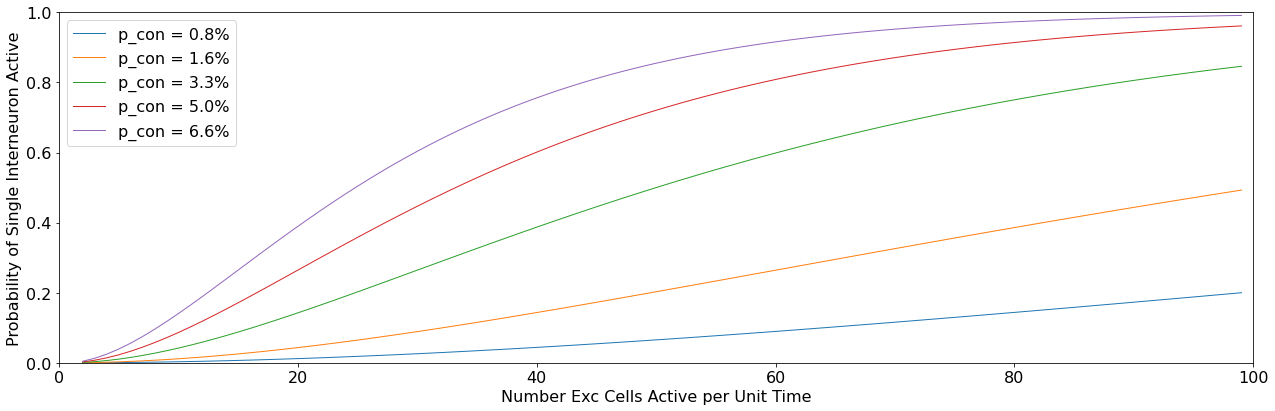

In [142]:
gs = gridspec.GridSpec(1, 1)
fig = plt.figure(figsize=(18, 6), tight_layout=True)
axs = [fig.add_subplot(gs[0])]

n_e_active = np.arange(0, 100)
n_e_i_partners = [5, 10, 20, 30, 40]

for n_e_partner_num in n_e_i_partners:
    p_con_e_i = n_e_partner_num / N_E
    label = str(p_con_e_i * 100)
    label = label[:label.find('.') + 2]
    axs[0].plot(n_e_active, prob_inh_neuron_active(p_con_e_i, n_e_active, N_E_THRESH), lw=1, label=f'p_con = {label}%')

axs[0].set_xlim(0, 100)
axs[0].set_ylim(0, 1)

axs[0].set_xlabel('Number Exc Cells Active per Unit Time')
axs[0].set_ylabel('Probability of Single Interneuron Active')
axs[0].legend()

In [143]:
def prob_n_inh_active(p_con_e_i, n_e_active, n_e_thresh, n_i):
    p_single = prob_inh_neuron_active(p_con_e_i, n_e_active, n_e_thresh)
    k = np.arange(n_i)
    
    probs = np.stack([1. - scipy.special.betainc(n_i - k, k + 1, 1. - p_s) for p_s in p_single])
    return probs

## Total number of interneurons active as function of active E neurons

We can compute the number of interneurons active at a moment in time by assuming the probability of activating each interneuron is independent, computing the probability that at least $n_{I, active}$ interneurons are active, and taking the derivative of this probability with respect to $n_{I, active}$.

The probability of turning on $> n_{I, active}$ interneurons given $n_{I}$ total interneurons and $n_{E, active}$ E neurons is:

$$P_{> n_{I, active}}(n_{E, active}) = 1 - I_{1 - P_{1, int}(n_{E, active})}(n_{I} - n_{I, active}, n_{I, active} + 1) $$

In [144]:
def plot_prob_n_inh_active(p_con, n_e_thresh):
    gs = gridspec.GridSpec(1, 1)
    fig = plt.figure(figsize=(18, 6), tight_layout=True)
    axs = [fig.add_subplot(gs[0])]
    
    n_e_active_range = (0, 200)
    
    n_e_active = np.arange(n_e_active_range[0], n_e_active_range[1])
    
    p_con_label = str(p_con * 100)
    p_con_label = p_con_label[:p_con_label.find('.') + 2]

    axs[0].set_title(f'p_con = {p_con_label}%, n_e_thresh = {n_e_thresh}\n')
    axs[0].matshow(prob_n_inh_active(p_con, n_e_active, n_e_thresh, N_I).T, aspect='auto')
    axs[0].set_xlim(n_e_active_range[0], n_e_active_range[1])
    axs[0].set_ylim(0, 600)
    axs[0].set_xlabel('Number Exc Cells Active per Unit Time')
    axs[0].set_ylabel('Number Inteneurons Active per Unit Time')

Here, we plot the probability that $n_{I, active}$ interneurons are active as a function of the active E cells, $n_{E, active}$ for a few parameter pairs of the connection probability E->I and the number of E cells required to activate an interneuron, $n_{E, thresh}$.

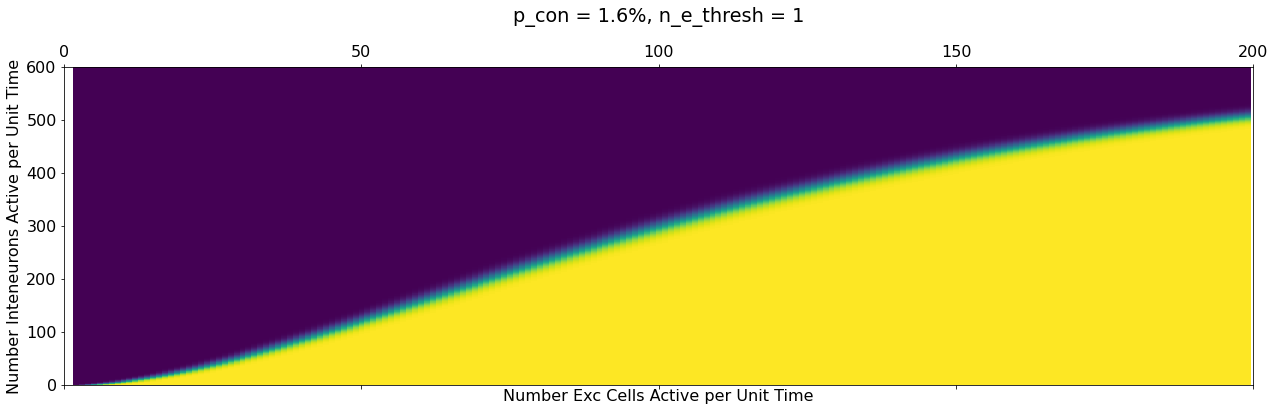

In [145]:
plot_prob_n_inh_active(10/600, 1)

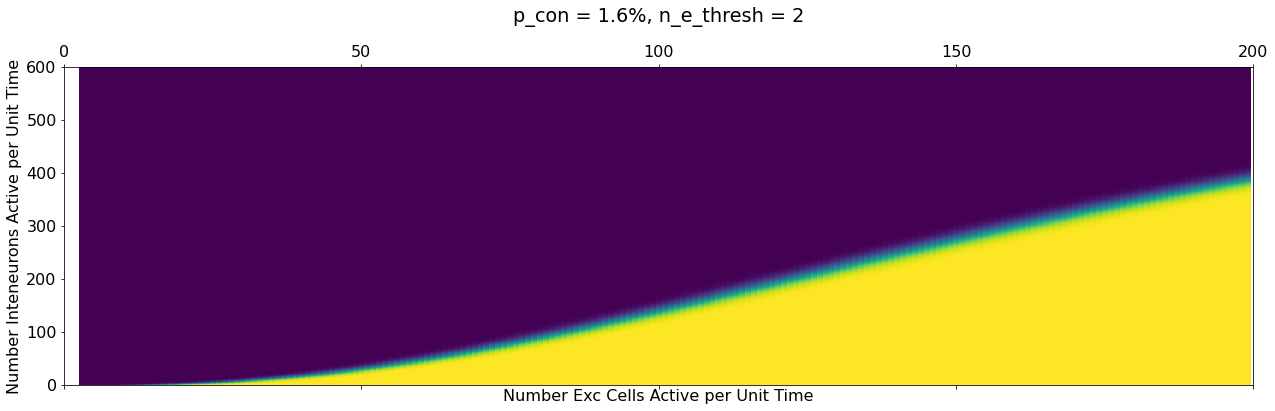

In [146]:
plot_prob_n_inh_active(10/600, 2)

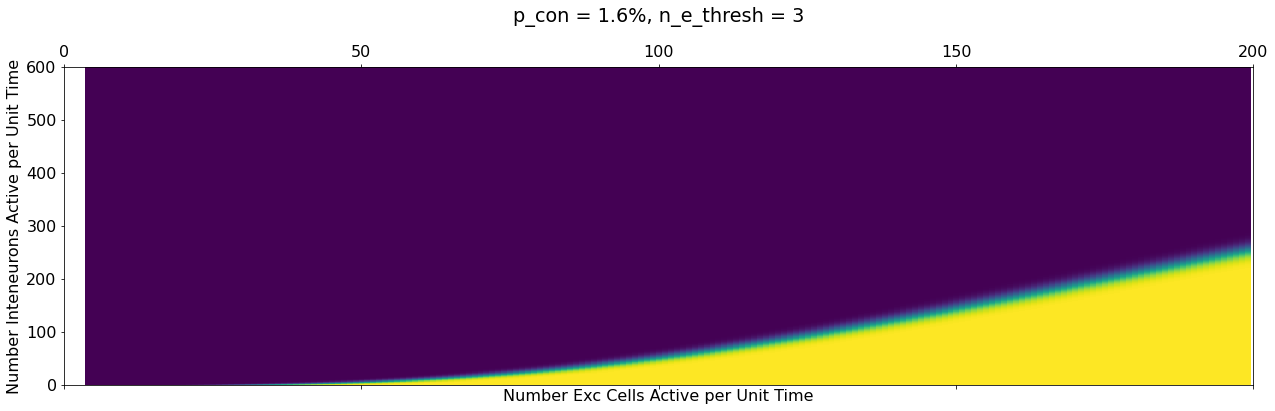

In [147]:
plot_prob_n_inh_active(10/600, 3)

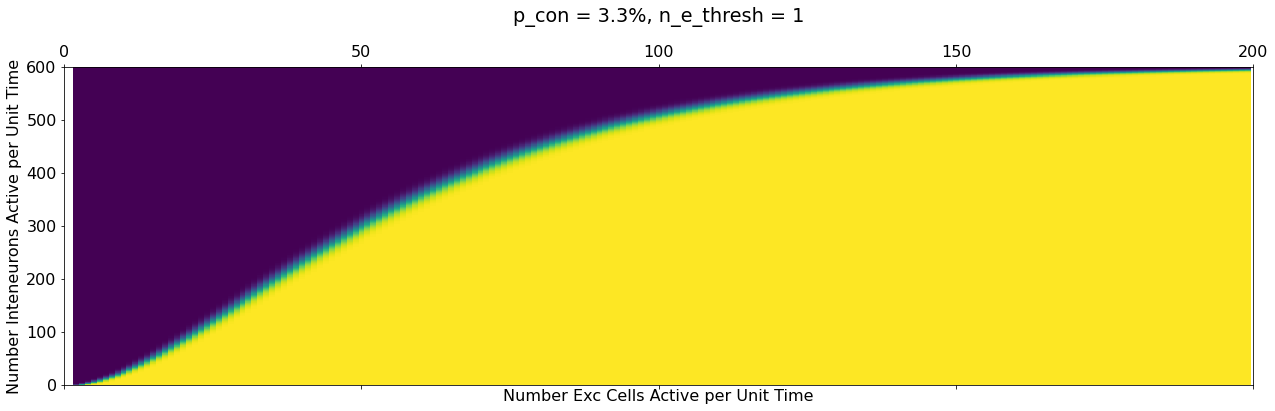

In [148]:
plot_prob_n_inh_active(20/600, 1)

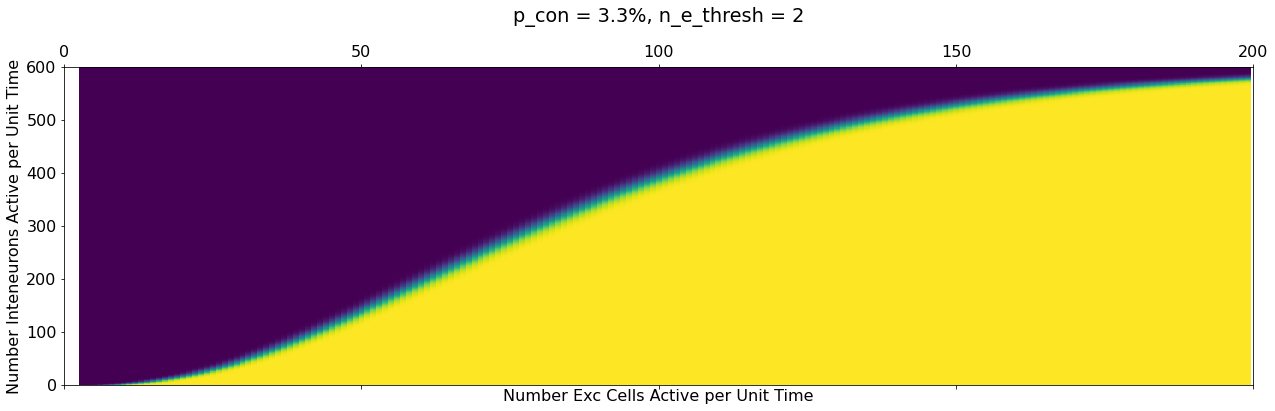

In [149]:
plot_prob_n_inh_active(20/600, 2)

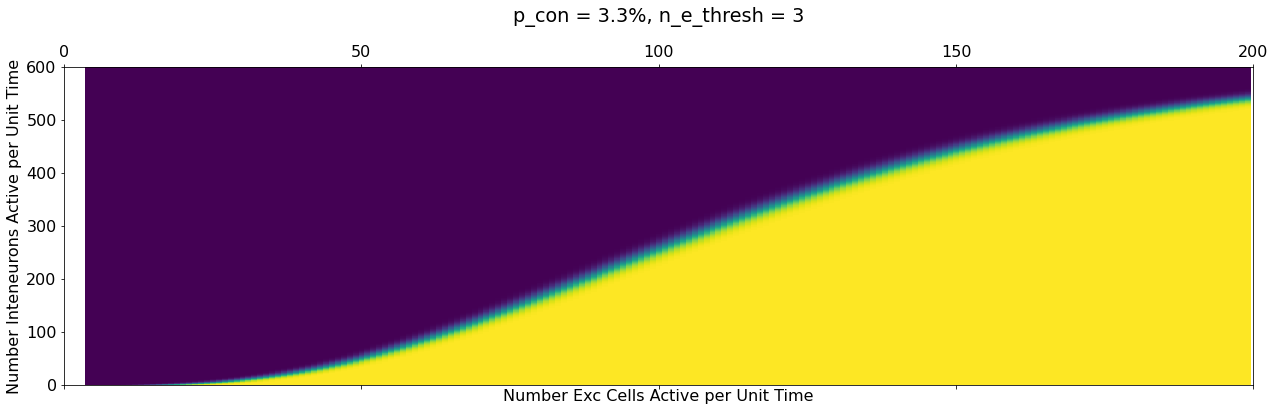

In [150]:
plot_prob_n_inh_active(20/600, 3)

Perturbation of the projection cells in HVC should roughly halve the number of incoming E connections per interneuron. If feed-forward weights between E cells are scaled to reestablish sequential activity, this may cause each E cell to fire more, effectively reducing the number of E cells driving an interneuron required to bring that interneuron to threshold. Further, if the input to interneurons becomes more coherent as it is coming from fewer cells, it might greatly decrease $n_{E, thresh}$.

This might lead to a scenario in which perturbation + scaled feed-forward weights actually leads to a greater average response from the inhibitory pool. Consider two example from below. The latter has half the connection probability but a much lower $n_{E, thresh}$.

This is precisely the response that would be required of the inhibitory pool for it to offset a large increase in excitatory feed-forward weights.

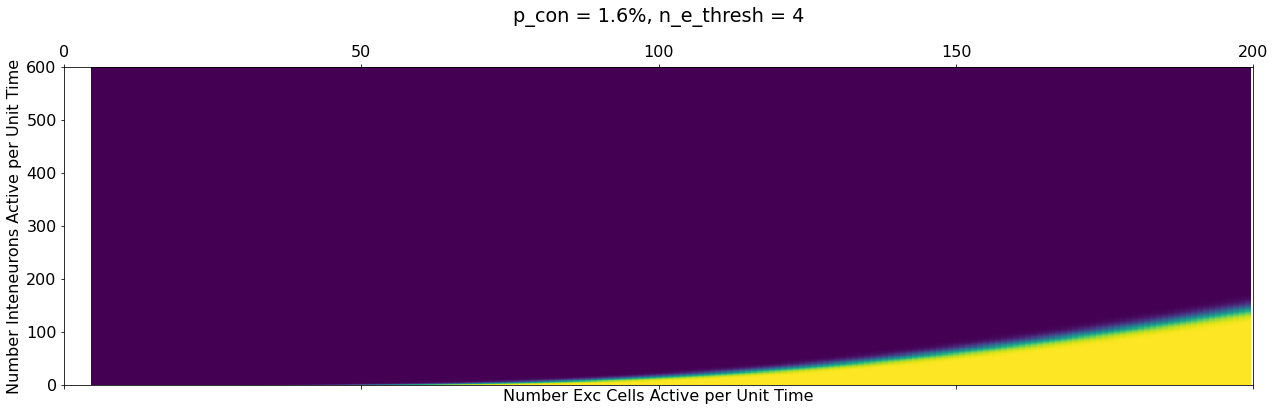

In [153]:
plot_prob_n_inh_active(10/600, 4)

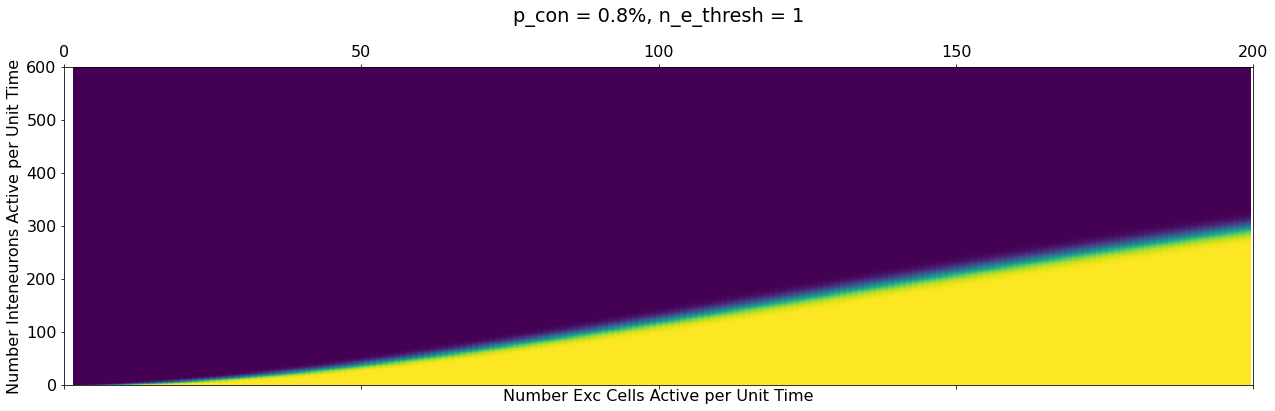

In [152]:
plot_prob_n_inh_active(5/600, 1)